<a href="https://colab.research.google.com/github/chetan015/deep-learning/blob/master/Assignment-11/Assignment-11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Start with base CIFAR-10 network

2. Add CutOut

3. Use LR Finder to find the best starting learning rate

4. Use SDG with Momentum

5. Train for 100 Epochs. 

6. Keep Verbose = 0 (no logs)

7. Print the top accuracy

8. Show Training and Test Accuracy curves

9. Run GradCAM on the any 25 misclassified images. Make sure you 
mention what is the prediction and what was the ground truth label.


In [1]:
from keras import backend as K
import time
import math
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LambdaCallback
import cv2

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


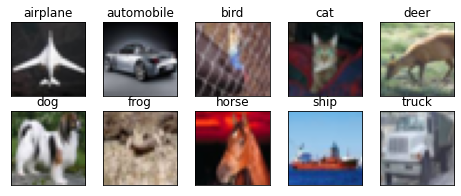

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
# Define the model
def create_model():
  model = Sequential()
  model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Convolution2D(32, 1, 1))


  model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Convolution2D(32, 1, 1))


  model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same',name="conv_8"))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Convolution2D(10, 1, 1))

  model.add(AveragePooling2D(pool_size = (4,4)))
  model.add(Flatten())


  model.add(Activation('softmax'))
  return model
model = create_model()
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regulariz

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)       

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return 

In [0]:
from keras.callbacks import Callback
import os
import keras.backend as K

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])


In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0, v_h=1,pixel_level=True))
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/64))
#model.fit(X_train, Y_train, callbacks=[lr_finder] )

model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 64),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 5, 
                                 callbacks=[lr_finder],verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., callbacks=[<__main__..., verbose=1, steps_per_epoch=781, epochs=5)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/5
607/781 [======================>.......] - ETA: 5s - loss: 2.5209 - accuracy: 0.3205

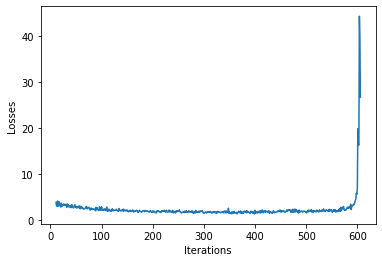

In [14]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss()

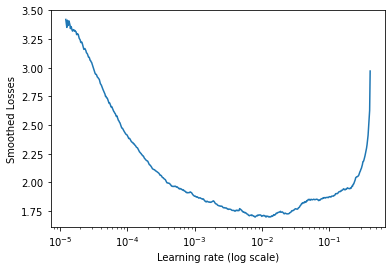

In [15]:
lr_finder.plot_smoothed_loss()

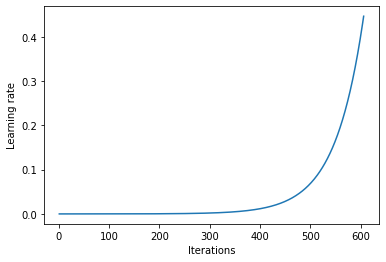

In [16]:
lr_finder.plot_lr()

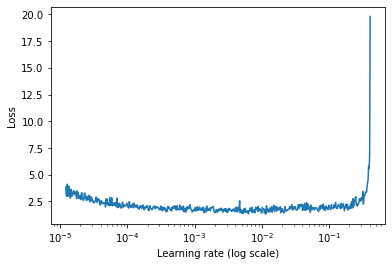

In [17]:
lr_finder.plot()

In [18]:
# Create SGD optimizer with found lr
from keras.optimizers import SGD
sgd = SGD(learning_rate=0.01, momentum=0.9)

# Create checkpoint and plateau monitor callbacks

model = create_model()

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import optimizers

# checkpointer = ModelCheckpoint(filepath='model_session11.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
# lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regulariz

In [23]:
# Train for 100 epochs with SGD lr=0.01 and cutout
model = create_model()
model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0, v_h=1,pixel_level=True))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=0)
end = time.time()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regulariz

Model took 571.39 seconds to train


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


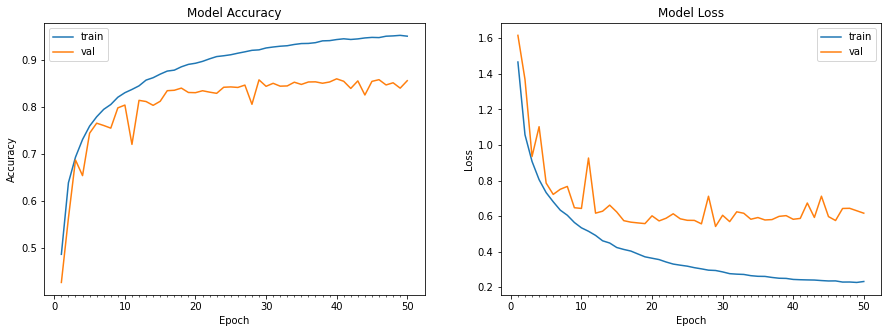

Accuracy on test data is: 85.55


In [24]:
# Plot the accuracy curves
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
def gradCam(imageID, model): 
  #print(preds[imageID])
  #print(class_idx)
  #find the class id of the prediction of Image
  class_idx = np.argmax(preds[imageID])
  class_output = model.output[:, class_idx]
  
  #get the last convolutional layer
  last_conv_layer = model.get_layer("conv2d_31")
  #get the gradients of the last layer
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  #pool the gradients over all the axes
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  testImage = test_features[imageID]
  testImage = testImage.reshape(1,32,32,3)
  pooled_grads_value, conv_layer_output_value = iterate([testImage])

  for i in range(128):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  img = test_features[imageID]

  #build a heatmap 
  
  #average the weighted feature map
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  #RELU
  heatmap = np.maximum(heatmap, 0)
  #normalize between 0 and 1
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = heatmap.astype('float32')
  plt.imshow(heatmap)
  #superimpose the heatmap over original image
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.5, 0,dtype=cv2.CV_32F)
  
  #return the superimposed iaage
  return superimposed_img

In [48]:
preds = model.predict(test_features)
missClassifiedIdx = np.random.permutation([i for i in range(len(test_features)) if np.argmax(preds[i]) != np.argmax(test_labels[i])])[:25]
print(missClassifiedIdx)

[2111 6436 3899 1684 9643 5233 8268 6383 2375 3996 7839  725 2948 7446
 5719 1779 2888 6245 7112 5272 6723 3052 3524 4404 4135]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

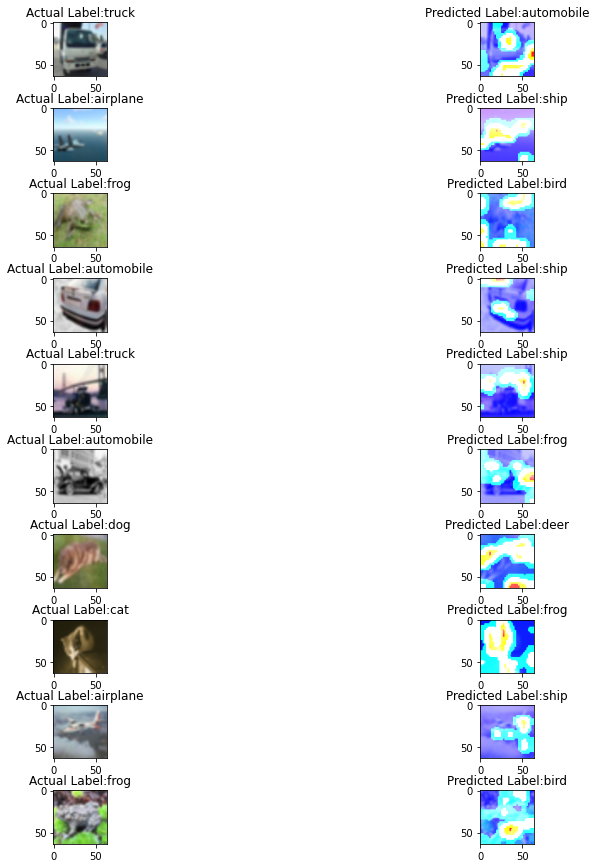

In [55]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
fig, ax = plt.subplots(10, 2, figsize = (12,12))
fig.tight_layout()
className = lambda a:class_names[np.argmax(a)]
for i,idx in enumerate(missClassifiedIdx[:10]):
  ax[i,0].imshow(resize(test_features[idx],(128,128)))
  ax[i,0].set_title("Actual Label:"+class_names[np.argmax(test_labels[idx])])
  b,g,r = cv2.split(gradCam(idx,model))       # get b,g,r
  rgb_img = cv2.merge([r,g,b])     # switch it to rgb
  ax[i,1].imshow(resize(rgb_img,(128,128)))
  ax[i,1].set_title("Predicted Label:"+class_names[np.argmax(preds[idx])])